In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_size):
        super(SelfAttention, self).__init__()
        self.embedding_size = embedding_size
        self.w_q = nn.Linear(embedding_size, embedding_size, bias = False)
        self.w_k = nn.Linear(embedding_size, embedding_size, bias = False)
        self.w_v = nn.Linear(embedding_size, embedding_size, bias = False)
        self.fc_out = nn.Linear(embedding_size, embedding_size, bias = False)
    
    def forward(self, query, key, value):
        query = self.w_q(query)
        key = self.w_k(key)
        value = self.w_v(value)

        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * (self.embedding_size ** - 0.5)
        attention_scores = F.softmax(attention_scores, dim = -1)
        attention_out = torch.matmul(attention_scores, value)

        attention_out = self.fc_out(attention_out)
        return attention_out


In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.head_dims = self.embedding_size // self.num_heads

        assert (self.num_heads * self.head_dims == self.embedding_size), \
            "embedding_size should be divisible by num_heads"
        
        self.w_q = nn.Linear(self.head_dims, self.head_dims, bias = False)
        self.w_k = nn.Linear(self.head_dims, self.head_dims, bias = False)
        self.w_v = nn.Linear(self.head_dims, self.head_dims, bias = False)
        self.fc_out = nn.Linear(self.head_dims, self.head_dims, bias = False)

    def forward(self, query, key, value):
        batch_size = query.shape[0]
        sequence_length_q, sequence_length_k, sequence_length_v = query.shape[1], key.shape[1], value.shape[1]

        query = query.reshape(batch_size, sequence_length_q, self.num_heads, self.head_dims)
        key = key.reshape(batch_size, sequence_length_k, self.num_heads, self.head_dims)
        value = value.reshape(batch_size, sequence_length_v, self.num_heads, self.head_dims)

        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * (self.embedding_size ** -0.5)
        attention_scores = F.softmax(attention_scores, dim = -1)
        attention_out = torch.matmul(attention_scores, value)

        attention_out = attention_out.reshape(batch_size, sequence_length_q, self.num_heads*self.head_dims)
        return attention_out


In [6]:
batch_size, sequence_length, embedding_size = 1, 77, 768

query = torch.rand(batch_size, sequence_length, embedding_size)
key = torch.rand(batch_size, sequence_length, embedding_size)
value = torch.rand(batch_size, sequence_length, embedding_size)

self_attention = SelfAttention(embedding_size)
result = self_attention(query, key, value)
print(result.shape)

torch.Size([1, 77, 768])


In [5]:
batch_size, sequence_length, embedding_size = 1, 77, 768
num_head = 6
query = torch.rand([batch_size, sequence_length, embedding_size])
key = torch.rand([batch_size, sequence_length, embedding_size])
value = torch.rand([batch_size, sequence_length, embedding_size])
multi_head_self_attention = MultiHeadSelfAttention(embedding_size, num_head)
attention_out = multi_head_self_attention(query, key, value)

#### 关于self-attention的一些常见的问题?

##### Q1: self-attention的公式中, q和k.T相乘后, 为什么需要除以一个数？

1. 在自注意力的计算公式中, Q和K的转置相乘后会生成一个注意力分数的矩阵, 在这个矩阵中每个元素都代表者不同位置之间的相似性。因为我们接下来会在利用一个softmax来生成0-1之间的注意力权重。但是我们观察softmax的图像后,我们发现,如果x的值太大或者太小时,y的值会接近0或者1,这样的话就会产生梯度消失的现象,从而影响了模型的学习效果。
所以, 我们需要一个对得到的矩阵进行一个缩放的处理, 从而到X的值相对集中一些。

##### Q2：那么,为什么一定是除以根号dk呢？为什么不是除以dk呢？

1. 我们首先假设Q和K和服从标准正态分布的,也就是它们的均值为0,方差为1。那么Q和dk的点积的期望值是0,方差为dk。如果我们是除dk的话, 则按照方差的计算公式, 方差为变为dk分支1, 这就使得结果比较小, 甚至接近于0。那么softmax输出的注意力权重就会比较平均, 这并不能突出重要的关系。
    所以我们可以除以根号dk, 这样的话, 最后的方差就会变为1。从而使得softmax输出的结果比较稳定, 梯度也比较适中, 有利于反向传播中的梯度更新。

#### Q3:multi-head self-attention的作用是什么？


1. 使用了多头自注意力机制,可以丰富表达能力。单头自注意力机制在每个时刻只能基于一个权重分布来计算注意力,这可能限制了模型捕捉不同类型依赖关系的能力。多头自注意力机制通过使用多个独立的注意力头,每个头都可以学习到不同的权重分布,从而捕捉不同位置之间的多种依赖关系。

2. 多头自注意力机制可以从多个角度,多个视角来理解输入序列,从而提高模型的表达能力。

3. 多头自注意力机制可以通过并行的方式来加速计算过程,提升了效率。

#### Q4: attention-mask是干嘛的？

1. 在使用mask时，通常是在计算Attention Scores后、应用softmax之前。具体地说，mask用于将某些位置的Attention Scores设置为一个非常小的值（通常是负无穷），这样在softmax归一化之后，这些位置的权重接近于零。

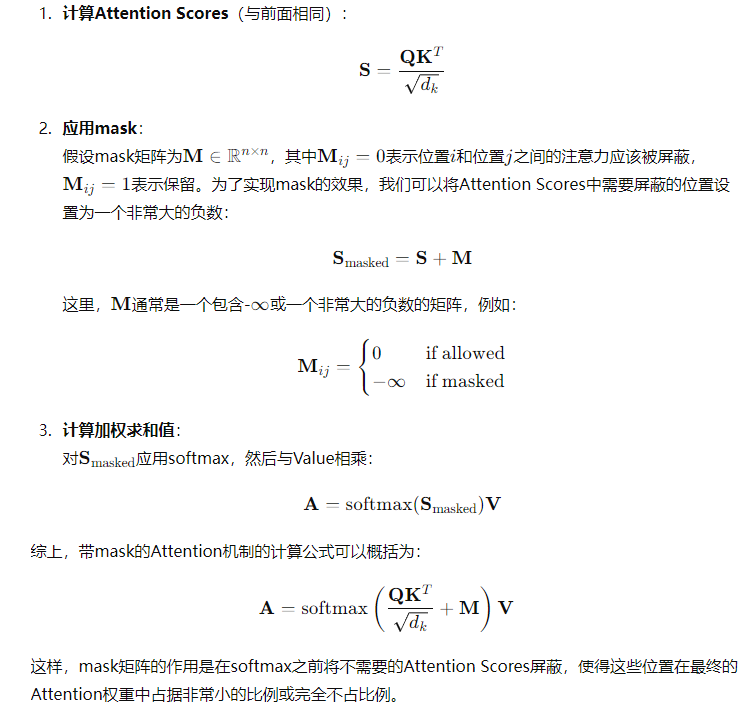